In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from os import path
import os

import astropy.coordinates as coord
from astropy.constants import G
from astropy.io import fits
from astropy.table import Table, QTable, join
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import emcee
import yaml

from hq.config import HQ_CACHE_PATH, config_to_alldata
from hq.plot import plot_two_panel, plot_phase_fold
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius

from thejoker.plot import plot_rv_curves
from thejoker import JokerSamples, JokerParams, TheJoker

from scipy.special import logsumexp
from scipy.stats import beta, truncnorm
from scipy.optimize import minimize

%aimport -numpy, scipy, astropy, tqdm, emcee

In [4]:
HQ_CACHE_PATH = '/Users/apricewhelan/projects/hq/cache'

In [5]:
samples_path = path.join(HQ_CACHE_PATH, 'dr16/samples')
metadata = QTable.read(path.join(HQ_CACHE_PATH, 'dr16/metadata-master.fits'))

with open(path.join(HQ_CACHE_PATH, "dr16/config.yml"), "r") as f:
    config = yaml.safe_load(f.read())
allstar, allvisit = config_to_alldata(config)

In [6]:
metadata = join(metadata, allstar, keys='APOGEE_ID')

As an initial demonstration, select a good pixel in the HR diagram and only run in there:

/Users/apricewhelan/anaconda/envs/hq/lib/python3.6/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


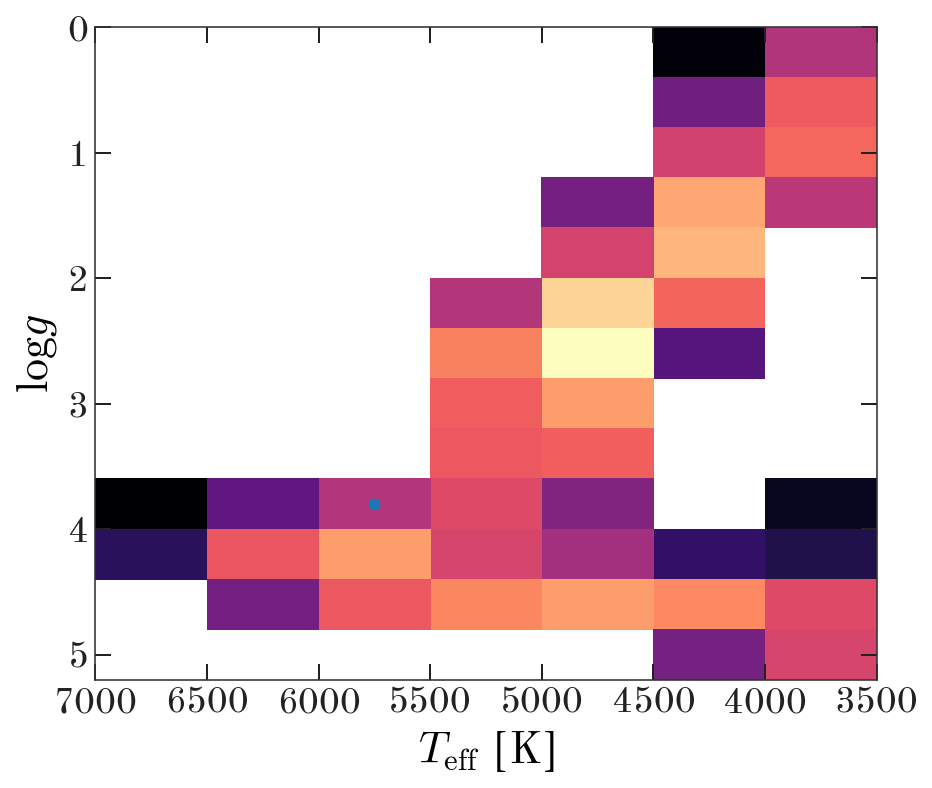

In [7]:
bins = (np.arange(3500, 7000+1e-3, 500),
        np.arange(0, 5.5+1e-3, 0.4))
H, xe, ye = np.histogram2d(allstar['TEFF'], allstar['LOGG'],
                           bins=bins)
H[H < 64] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
im = ax.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
# cell = [4750, 2.6]
cell = [5750, 3.8]
# cell = [4750, 4.6]
ax.scatter(*cell)
ax.set_xlim(bins[0].max(), bins[0].min())
ax.set_ylim(bins[1].max(), bins[1].min())

ax.set_xlabel(r'$T_{\rm eff}$ [K]')
ax.set_ylabel(r'$\log g$')

fig.set_facecolor('w')

In [11]:
from hq.hierarchical.period_ecc import Model

In [10]:
B1 = beta(1.5, 50.)
B2 = beta(1, 1.8)

In [17]:
ijs = []
reses = []
for i, (T1, T2) in enumerate(zip(xe[:-1], xe[1:])):
    for j, (l1, l2) in enumerate(zip(ye[:-1], ye[1:])):        
        pixel_mask = ((metadata['TEFF'] > T1) & (metadata['TEFF'] <= T2) & 
                      (metadata['LOGG'] > l1) & (metadata['LOGG'] <= l2))
        llr_mask = (metadata['max_unmarginalized_ln_likelihood'] - metadata['robust_constant_ln_likelihood']) > 8
        mask = (pixel_mask & llr_mask & 
                (metadata['unimodal'] | (metadata['joker_completed'] & (metadata['n_visits'] >= 8))))
        
        if mask.sum() < 64:
            continue
        
        # Load the samples:
        NSAMPLES = 256
        ez_samples = np.full((2, mask.sum(), NSAMPLES), np.nan)
        for n, apogee_id in enumerate(metadata[mask]['APOGEE_ID']):
            filename = path.join(samples_path, apogee_id[:4],
                                 '{}.fits.gz'.format(apogee_id))
            t = fits.getdata(filename)
            K = min(NSAMPLES, len(t))
            ez_samples[0, n, :K] = t['e'][:K]
            ez_samples[1, n, :K] = np.log(t['P'][:K])
        
        K_n = np.isfinite(ez_samples[0]).sum(axis=-1)
        K_n_mask = K_n > 32
        
        ln_e_p0 = beta.logpdf(ez_samples[0], a=0.867, b=3.03)
        ln_z_p0 = np.full_like(ez_samples[1], 
                               -np.log(np.log(65536) - np.log(2)))
        ln_p0_ez = np.stack((ln_e_p0, ln_z_p0))
        
        # for nulling out the probability for non-existing samples
        nan_mask = np.zeros_like(ez_samples)
        nan_mask[np.isnan(ez_samples)] = -np.inf
        
        mod = Model(ez_samples, K_n, ln_p0_ez, B1=B1, B2=B2)
        p0 = mod.pack_pars({'lnk': 0., 'z0': np.log(30.), 'alpha0': 0.2,
                            'muz': np.log(100), 'lnsigz': np.log(4.)})
        if not np.isfinite(mod(p0)):
            continue
        
        res = minimize(lambda *args: -mod(*args), x0=p0, method='powell')
        reses.append(res)
        
        ijs.append([i, j])
        print(i, j)

0 0
0 1
0 11
0 12
1 1
1 2


/Users/apricewhelan/anaconda/envs/hq/lib/python3.6/site-packages/scipy/optimize/optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


1 3
1 4
1 11
2 4
2 5
2 6
2 7
2 8
2 10
2 11
3 5
3 6
3 7
3 8
3 9
3 10
3 11
4 9
4 10
4 11
5 10


In [109]:
mod.unpack_pars(res.x)

{'lnk': 3.9999999999904587,
 'z0': 2.7503218910070992,
 'alpha0': 0.43373840229745725,
 'muz': 5.024862007783784,
 'lnsigz': 0.2861072230248132}

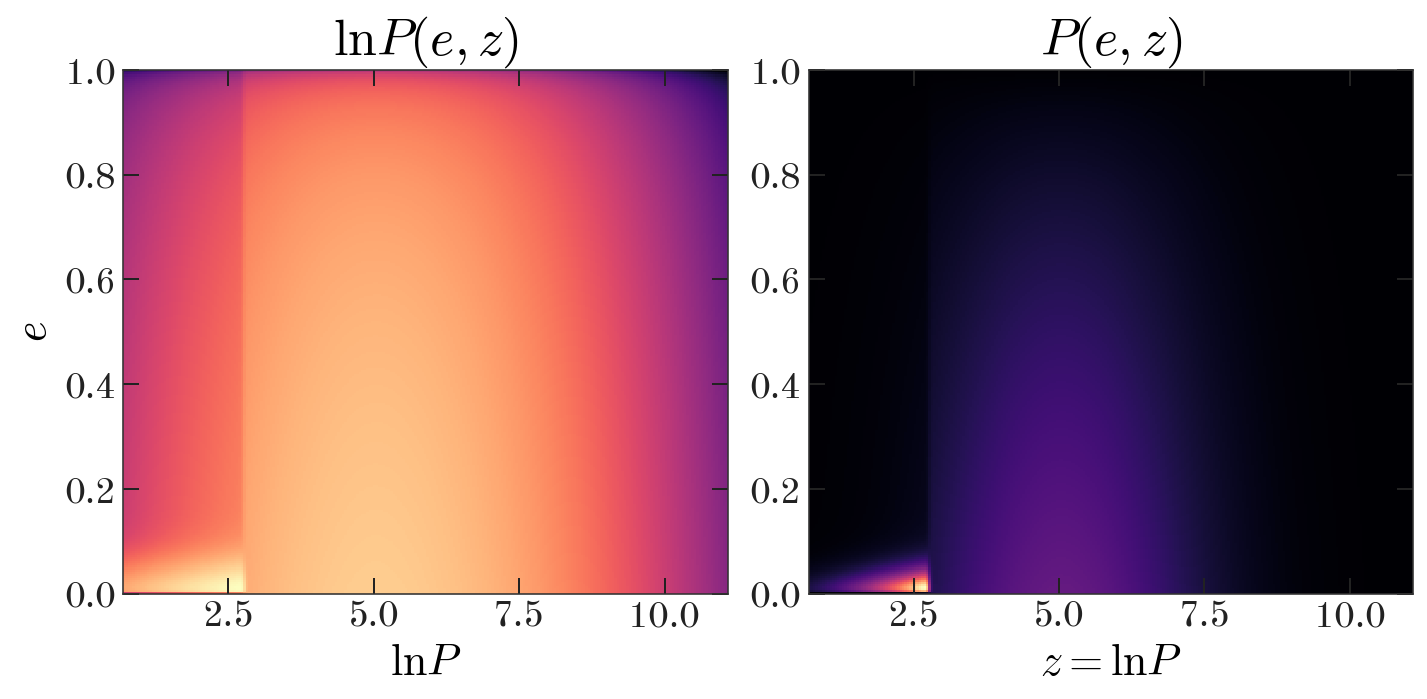

In [111]:
lnval_fit = np.sum(mod.ln_ze_dens(mod.unpack_pars(res.x), ee, zz), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(zz, ee, lnval_fit)
axes[1].pcolormesh(zz, ee, np.exp(lnval_fit))

axes[0].set_xlabel(r'$\ln P$')
axes[0].set_ylabel(r'$e$')
axes[1].set_xlabel(r'$z = \ln P$')

axes[0].set_title(r'$\ln P(e, z)$')
axes[1].set_title(r'$P(e, z)$')

fig.tight_layout()

In [112]:
e_lnw, z_lnw = mod.get_lnweights(mod.unpack_pars(res.x))

e_w = np.exp(e_lnw)
z_w = np.exp(z_lnw)

wi = e_w / np.sum(e_w, axis=1)[:, None]
K_eff_e = 1 / np.sum(wi**2, axis=1)

wi = z_w / np.sum(z_w, axis=1)[:, None]
K_eff_z = 1 / np.sum(wi**2, axis=1)

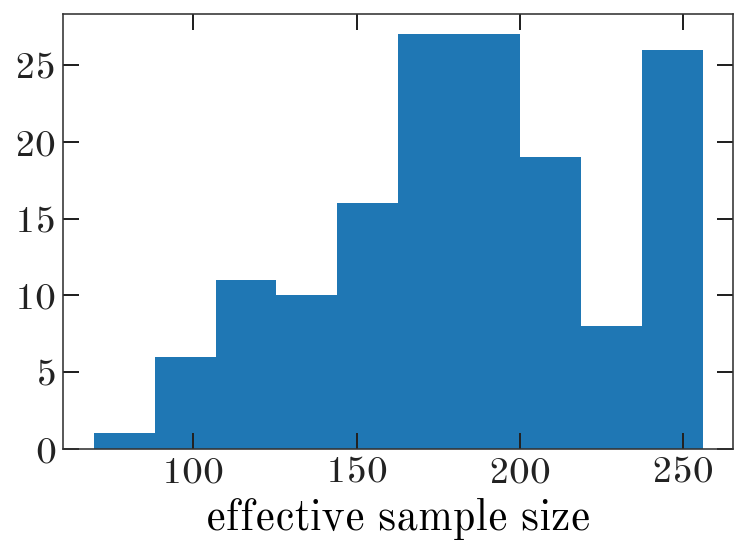

In [113]:
fig = plt.figure()
plt.hist(K_eff_e)
plt.xlabel('effective sample size')
fig.set_facecolor('w')

---

In [34]:
from schwimmbad import MultiPool

In [35]:
nparams = len(res.x)
nwalkers = 8 * nparams
all_p0 = emcee.utils.sample_ball(p0, [1e-3] * nparams, size=nwalkers)
nwalkers

40

In [36]:
with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, 
                                    ndim=nparams, 
                                    log_prob_fn=mod, 
                                    pool=pool)
    _ = sampler.run_mcmc(all_p0, 512, progress=True)

100%|██████████| 512/512 [12:47<00:00,  1.66s/it]


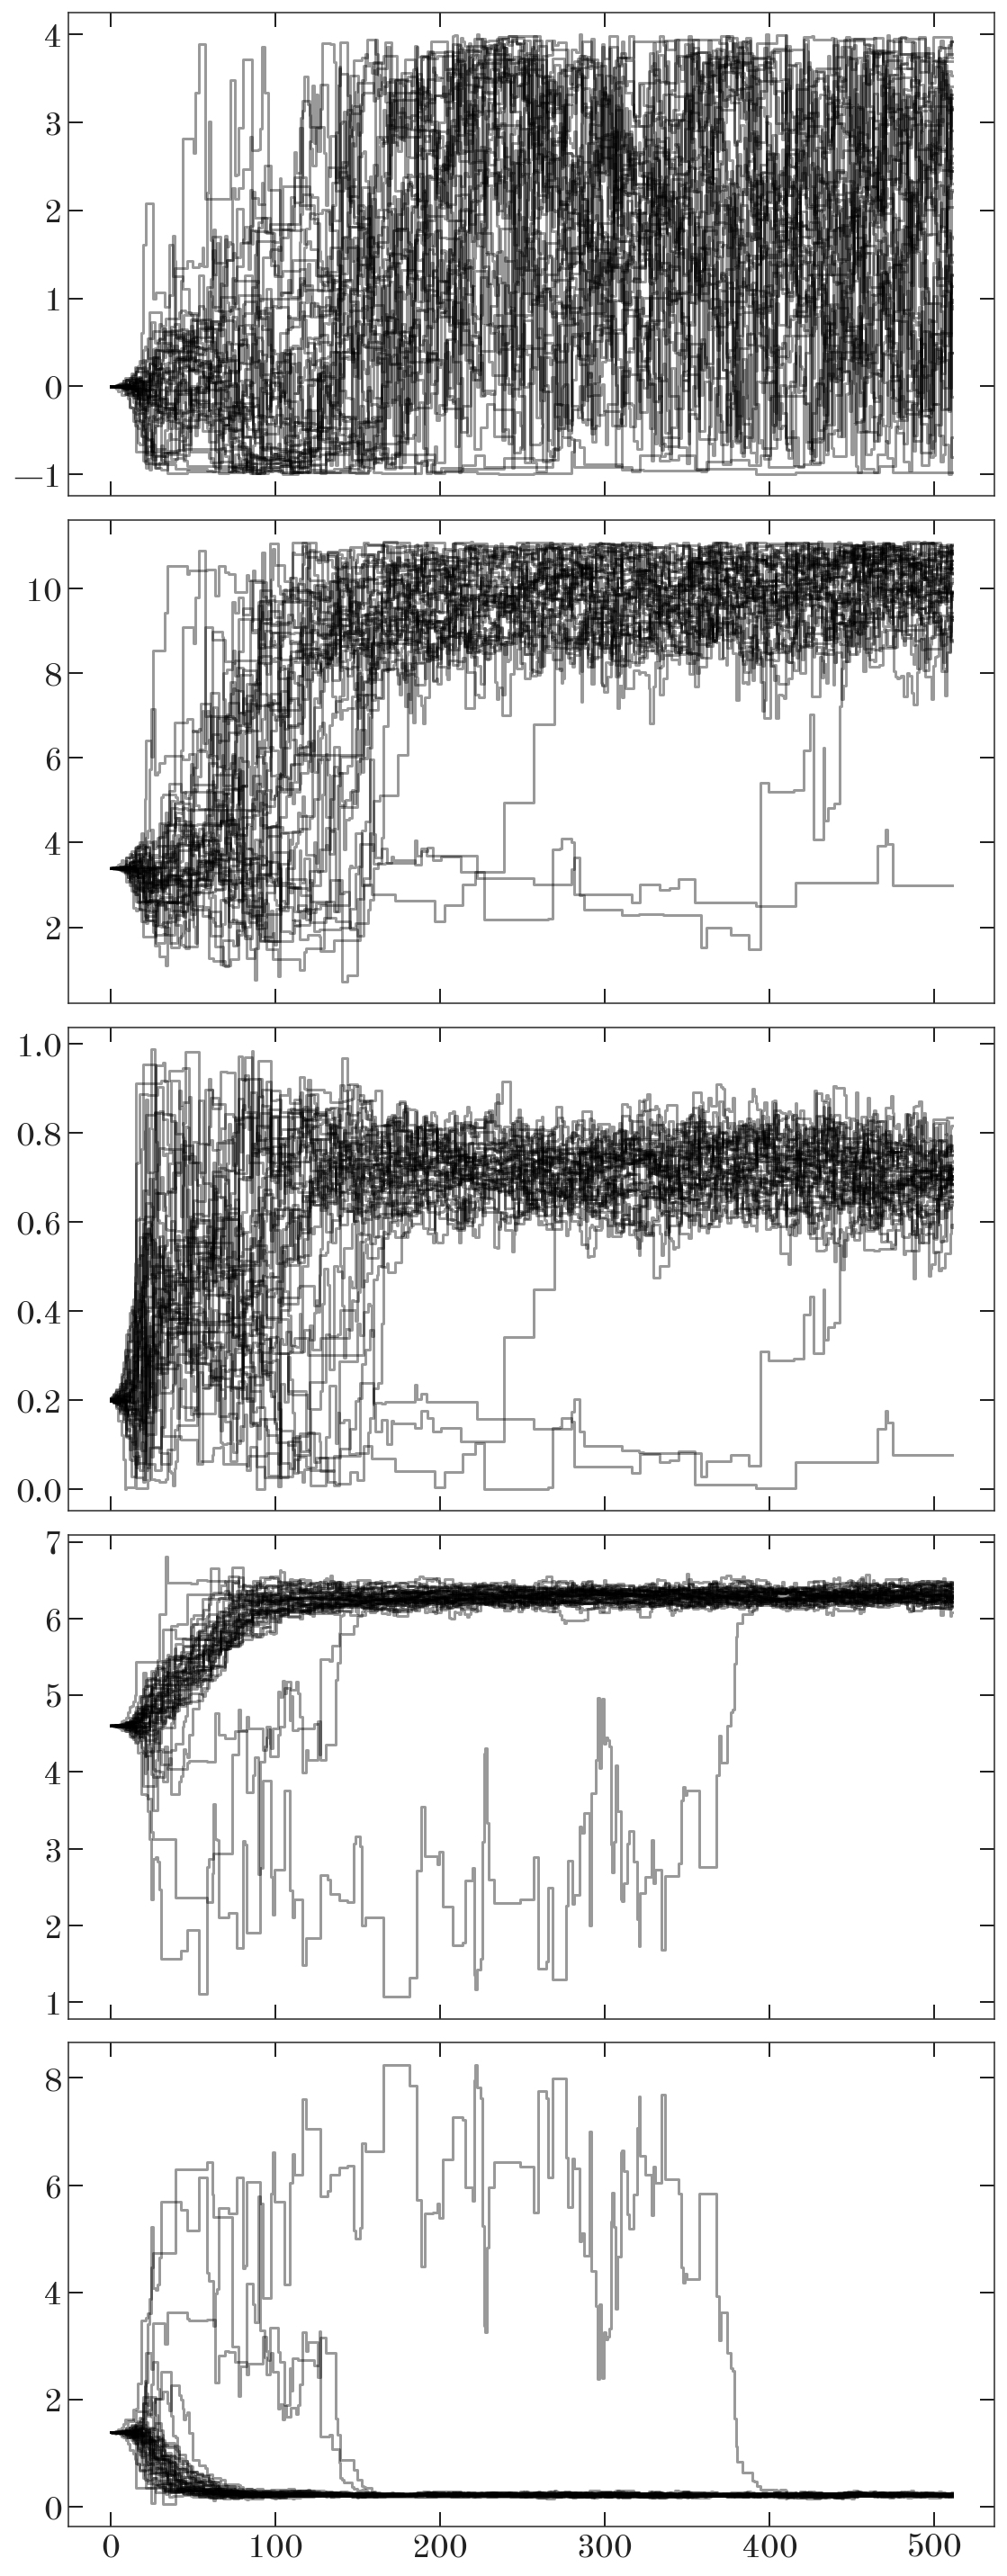

In [37]:
fig, axes = plt.subplots(nparams, 1, figsize=(8, 4*nparams), 
                         sharex=True)

for k in range(sampler.chain.shape[-1]):
    for walker in sampler.chain[..., k]:
        axes[k].plot(walker, marker='', 
                     drawstyle='steps-mid', alpha=0.4, color='k')        
fig.tight_layout()

In [38]:
pp = mod.unpack_pars(sampler.chain[0, -1])

In [39]:
zgrid = np.linspace(mod._zlim[0], mod._zlim[1], 252)
egrid = np.linspace(0, 1, 256)
zz, ee = np.meshgrid(zgrid, egrid)

lnval_init = np.sum(mod.ln_ze_dens(mod.unpack_pars(p0), ee, zz), axis=0)
lnval_min = np.sum(mod.ln_ze_dens(mod.unpack_pars(res.x), ee, zz), axis=0)
lnval_emcee = np.sum(mod.ln_ze_dens(pp, ee, zz), axis=0)

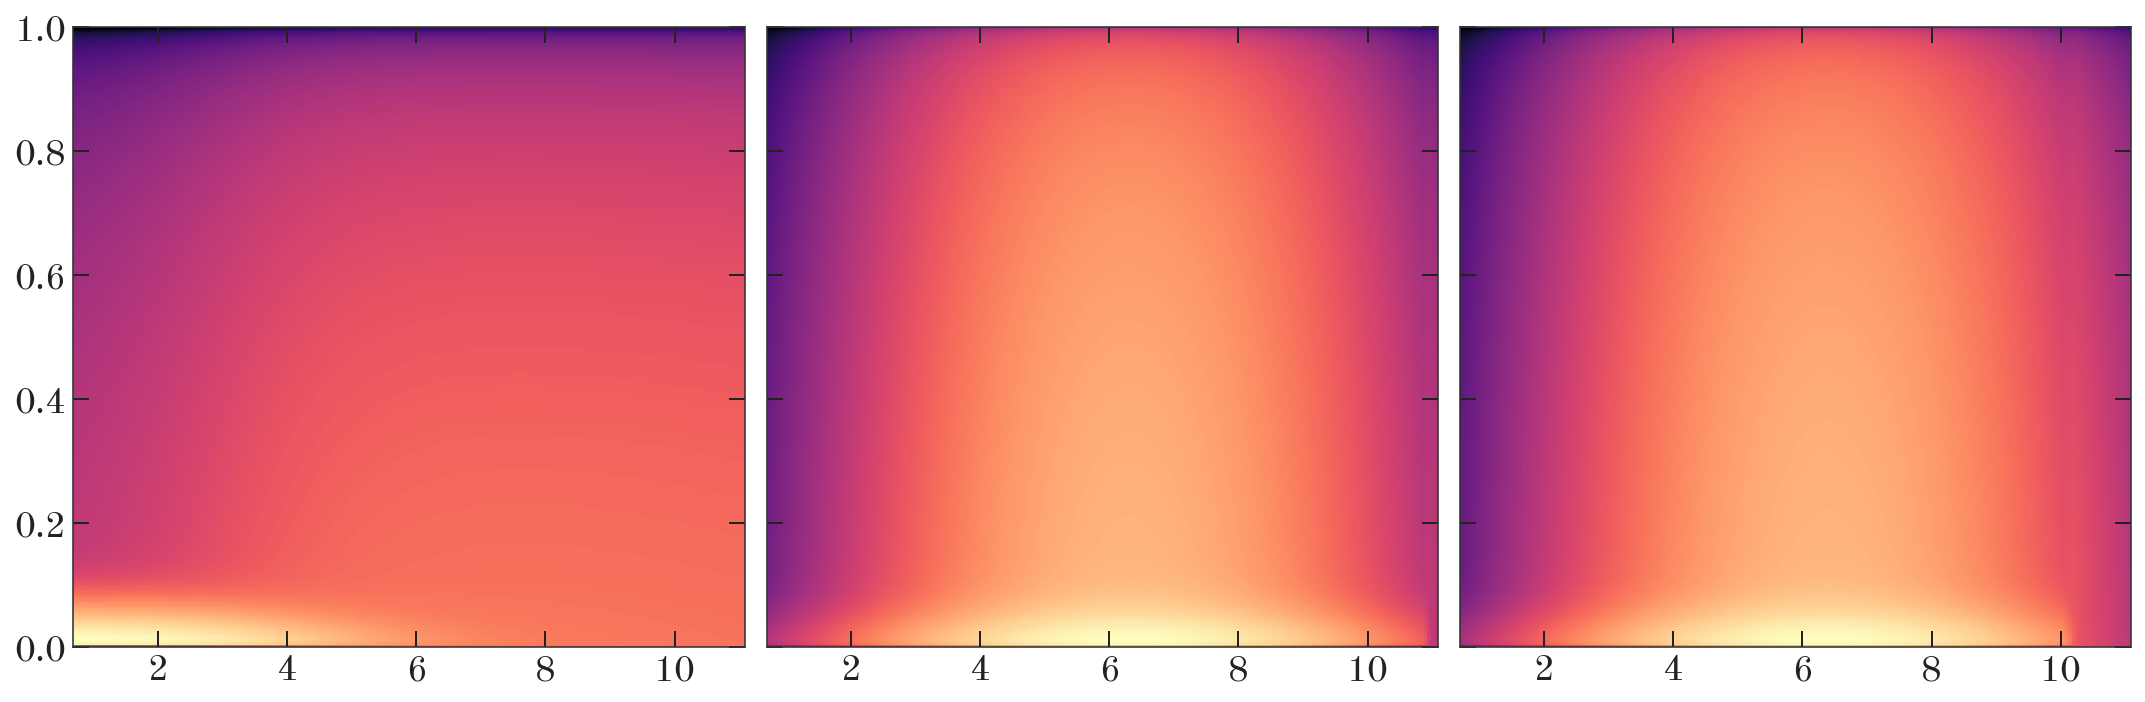

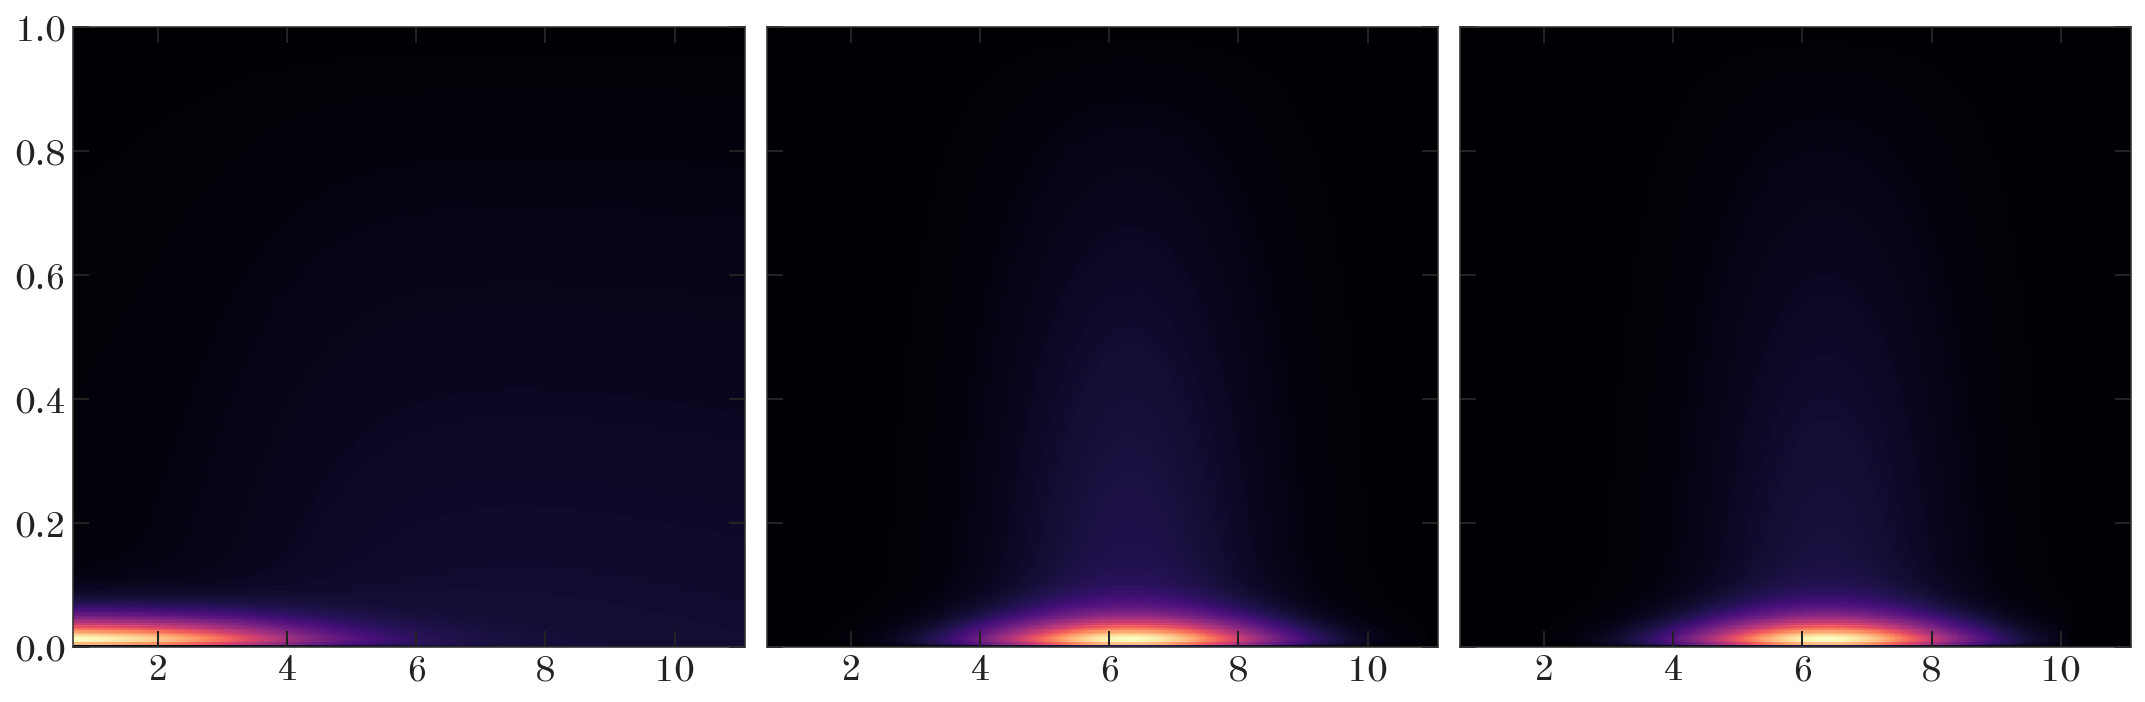

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].pcolormesh(zz, ee, lnval_init)
axes[1].pcolormesh(zz, ee, lnval_min)
axes[2].pcolormesh(zz, ee, lnval_emcee)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].pcolormesh(zz, ee, np.exp(lnval_init))
axes[1].pcolormesh(zz, ee, np.exp(lnval_min))
axes[2].pcolormesh(zz, ee, np.exp(lnval_emcee))
fig.tight_layout()

(0, 1)

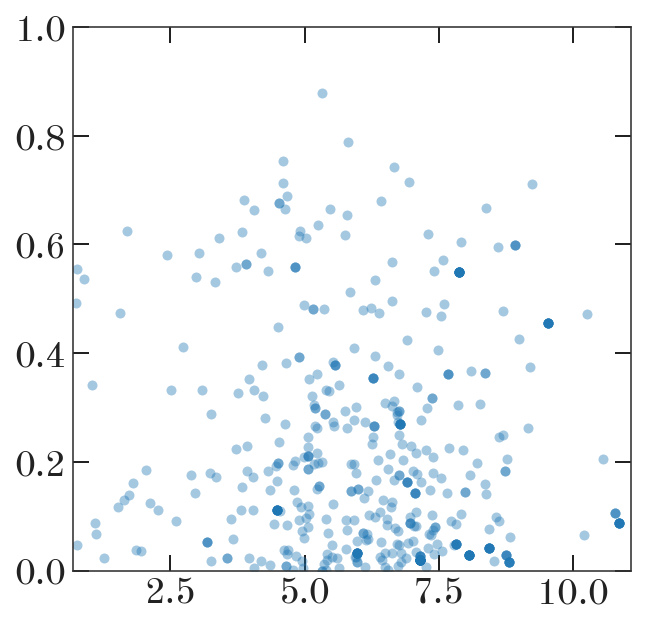

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(ez_samples[1].T, ez_samples[0].T, 
ax.plot(ez_samples[1, :, 0], ez_samples[0, :, 0], 
        marker='o', ls='none', alpha=0.4);
ax.set_xlim(zgrid.min(), zgrid.max())
ax.set_ylim(0, 1)

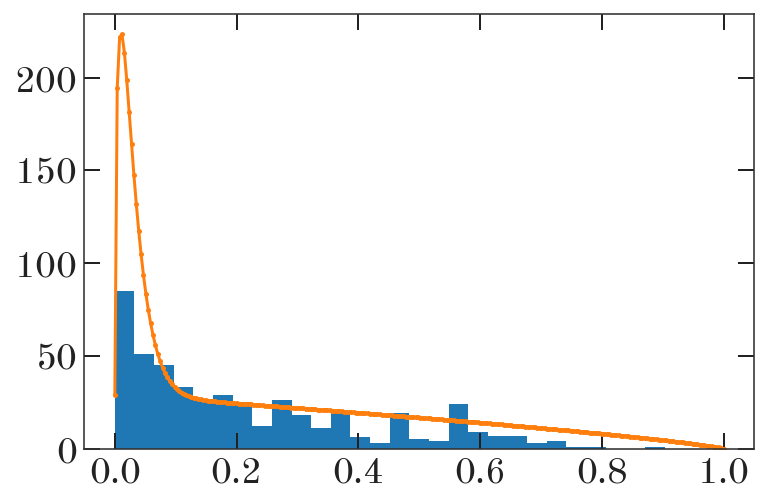

In [46]:
plt.hist(ez_samples[0, :, 0], bins=np.linspace(0, 1, 32));
plt.plot(egrid, np.exp(lnval_emcee).sum(axis=1))